## Inference Pipeline

In [1]:
import torch
import numpy as np
from omegaconf import OmegaConf
from scripts.joint_regressor import JointRegressor
from scripts.checkpoint_utils import load_full_checkpoint
from scripts.dlrhand2_joint_datamodule import _sample_mesh_as_pc


def load_model(
    joint_ckpt: str,
    config_path: str,
    backbone_ckpt: str | None = None,
    device: str = "cuda:0"
) -> JointRegressor:
    """Instantiate JointRegressor, optionally load a JEPA backbone, then load trained joint-ckpt weights."""
    # Load training config
    cfg = OmegaConf.load(config_path)

    # Build model with training hyperparams
    model = JointRegressor(
        num_points=cfg.data.num_points,
        tokenizer_groups=cfg.model.tokenizer_groups,
        tokenizer_group_size=cfg.model.tokenizer_group_size,
        tokenizer_radius=cfg.model.tokenizer_radius,
        encoder_dim=cfg.model.encoder_dim,
        encoder_depth=cfg.model.encoder_depth,
        encoder_heads=cfg.model.encoder_heads,
        encoder_dropout=cfg.model.encoder_dropout,
        encoder_attn_dropout=cfg.model.encoder_attn_dropout,
        encoder_drop_path_rate=cfg.model.encoder_drop_path_rate,
        encoder_mlp_ratio=cfg.model.encoder_mlp_ratio,
        pooling_type=cfg.model.pooling_type,
        pooling_heads=cfg.model.pooling_heads,
        pooling_dropout=cfg.model.pooling_dropout,
        head_hidden_dims=cfg.model.head_hidden_dims,
        lr_backbone=cfg.model.lr_backbone,
        lr_head=cfg.model.lr_head,
    )

    # Load backbone pretrain if provided
    if backbone_ckpt:
        load_full_checkpoint(model, backbone_ckpt)

    # Load full joint-regression checkpoint (overwrites head + backbone)
    checkpoint = torch.load(joint_ckpt, map_location=device)
    state = checkpoint.get('state_dict', checkpoint)
    model.load_state_dict(state, strict=False)

    model.eval()
    model.freeze()
    model.to(device)
    return model


@torch.inference_mode()
def predict_joint_angles(
    model: JointRegressor,
    mesh_path: str,
    pose7d: list[float] | np.ndarray,
    num_points: int | None = None,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Given a mesh file and a 7D hand pose, returns the 12-D joint-angle prediction.
    """
    n_pts = num_points or model.hparams.num_points
    pc = _sample_mesh_as_pc(mesh_path, n=n_pts)

    pts = torch.from_numpy(pc).unsqueeze(0).to(device)
    pose = torch.as_tensor(pose7d, dtype=torch.float32).unsqueeze(0).to(device)

    pred = model(pts, pose)  # (1,12)
    return pred.squeeze(0).cpu().numpy()

# Example usage:
# model = load_model(
#     joint_ckpt="checkpoints/joint-final.ckpt",
#     config_path="configs/train_joint.yaml",
#     backbone_ckpt="checkpoints/pretrain-pointjepa.ckpt",  # optional
#     device="cuda:0"
# )
# angles = predict_joint_angles(model, mesh_path, hand_pose)
# print(angles)


/home/jguzeel_gmail_com/jed-repo/ADLR/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using DIRECT mode, client ID: 3


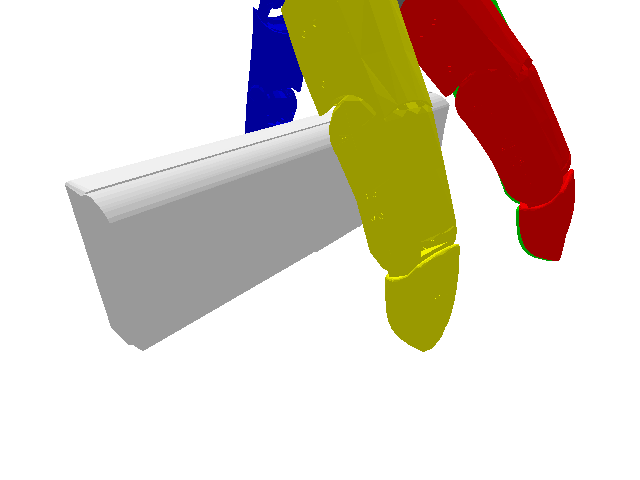

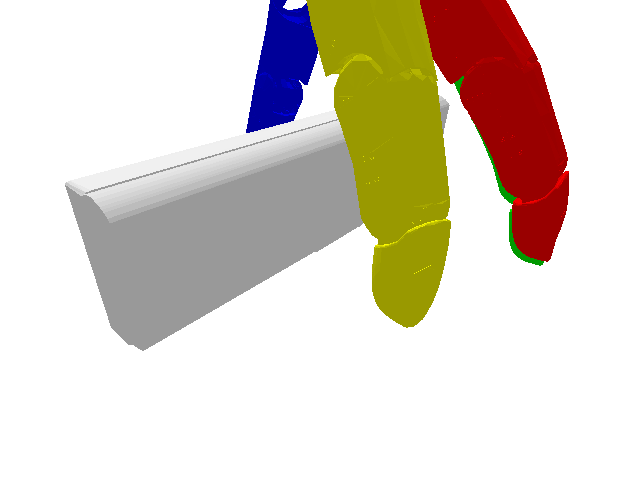

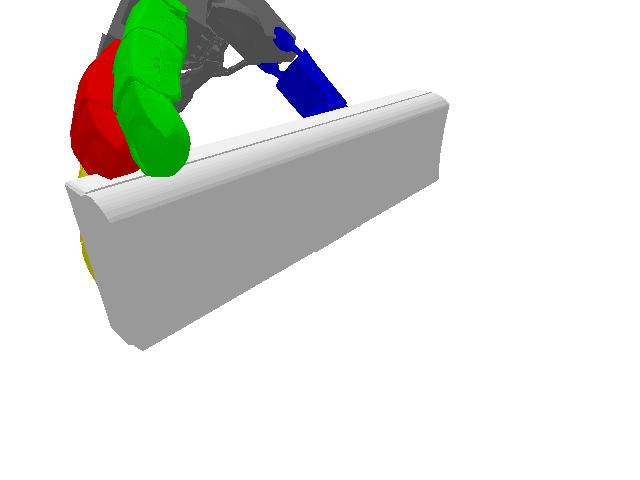

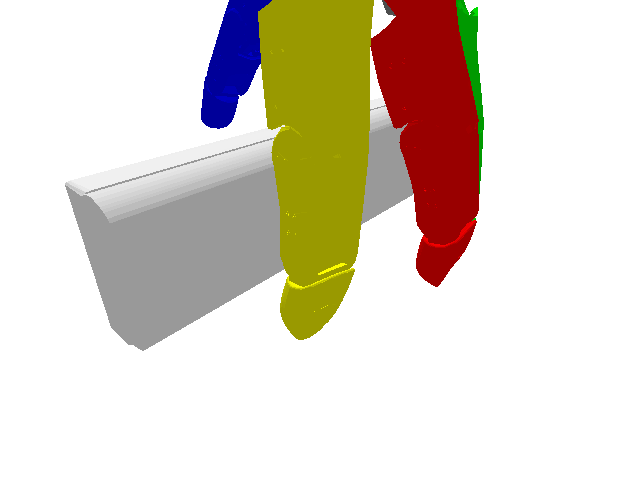

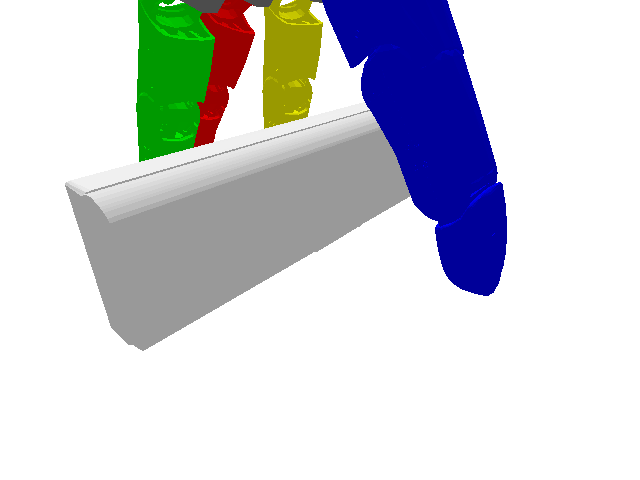

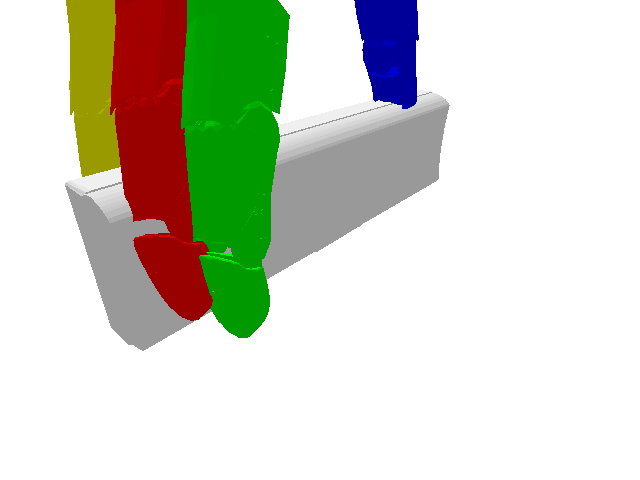

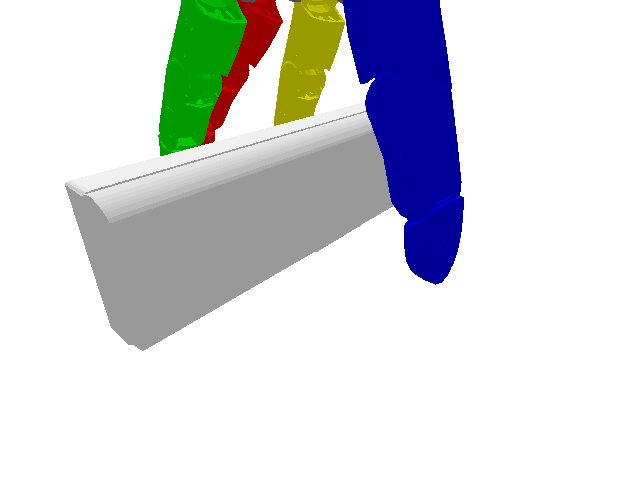

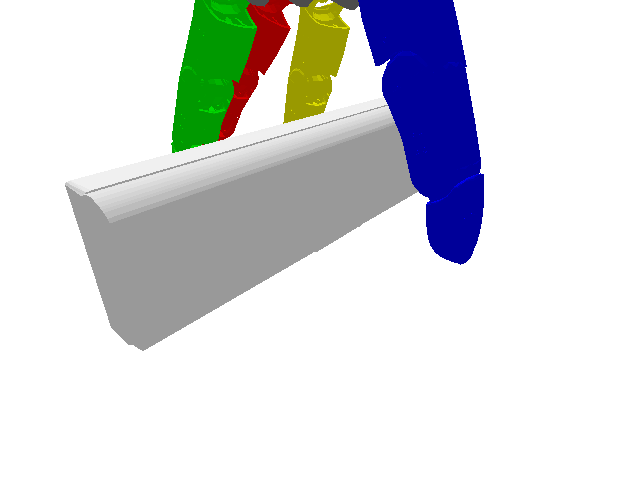

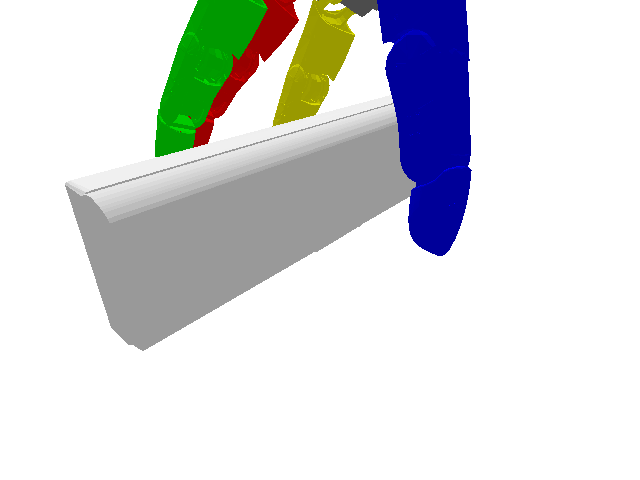

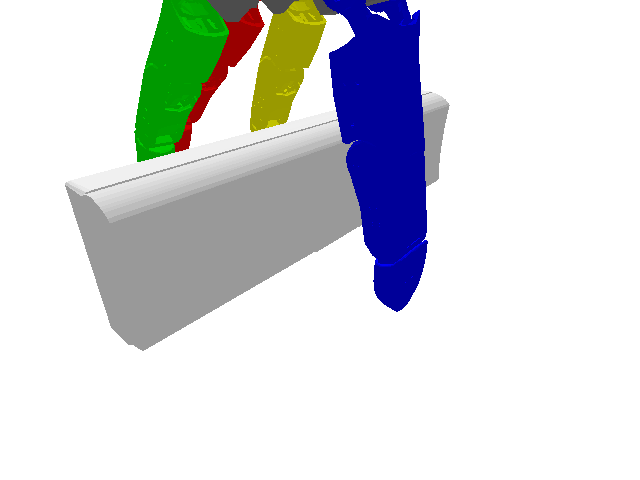

In [9]:
import pybullet as p, pybullet_data
import numpy as np
from pathlib import Path
from PIL import Image
from IPython.display import display
import time

# ── 1) Define your real data folder here ──
root = Path("../data/grasp_sample/03211117/2f12da0c7460b22cd3ab2bc0f53ca878/3")
mesh_f = root / "mesh.obj"
recording = root / "recording.npz"

assert mesh_f.exists(), f"Mesh not found at {mesh_f}"
assert recording.exists(), f"Recording not found at {recording}"

# ── 2) Connect headlessly ──
cid = p.connect(p.DIRECT)
print("Using DIRECT mode, client ID:", cid)

p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation(physicsClientId=cid)

# ── 3) Load your hand URDF once ──
hand_id = p.loadURDF(
    str(Path("../urdfs/dlr2.urdf").absolute()),  # update if your urdf is elsewhere
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)

# ── 4) Load object mesh once ──
v = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
c = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=str(mesh_f.resolve()),
    meshScale=1.0,
    physicsClientId=cid,
)
p.createMultiBody(
    baseVisualShapeIndex=v,
    baseCollisionShapeIndex=c,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    physicsClientId=cid,
)

# ── 5) Prepare model & data ──
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

data    = np.load(recording, allow_pickle=False)
poses7d = data["grasps"][:10, :7]   # pick first 3

# ── 6) Render loop ──
for i, pose7d in enumerate(poses7d):
    angles = predict_joint_angles(model, mesh_path=str(mesh_f), pose7d=pose7d)

    # reset pose & joints
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:], physicsClientId=cid)
    for a, j in zip(angles, [1,2,3,7,8,9,13,14,15,19,20,21]):
        p.resetJointState(hand_id, j, a, physicsClientId=cid)
        if j in {3,9,15,21}:
            p.resetJointState(hand_id, j+1, a, physicsClientId=cid)
    p.stepSimulation(physicsClientId=cid)

    # snapshot
    view = p.computeViewMatrixFromYawPitchRoll(
        cameraTargetPosition=[0,0,0], distance=0.3,
        yaw=45, pitch=-30, roll=0, upAxisIndex=2,
        physicsClientId=cid
    )
    proj = p.computeProjectionMatrixFOV(
        fov=60, aspect=640/480, nearVal=0.01, farVal=1.5,
        physicsClientId=cid
    )
    w, h, rgba, _, _ = p.getCameraImage(640, 480,
                                        viewMatrix=view,
                                        projectionMatrix=proj,
                                        physicsClientId=cid)
    img = Image.fromarray(rgba[:, :, :3])
    display(img)
    time.sleep(0.5)

p.disconnect(physicsClientId=cid)


In [15]:
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",            # your trained regressor
    config_path="../configs/train_joint.yaml",
    #backbone_ckpt="checkpoints/pretrain_pointjepa.ckpt",  # if you want to override backbone first
    device="cuda:0",
)

angles = predict_joint_angles(
    model,
    mesh_path="../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj",
    pose7d=[0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0],
)
print("Predicted joint angles:", angles)


Predicted joint angles: [-0.149     0.1322   -0.2136    0.09985  -0.1733   -0.04956   0.03072
 -0.09595   0.008736  0.028    -0.10754  -0.02014 ]


## PyBullet Script

In [16]:
"""
grasp_vis.py
============

Tiny utility to render a single grasp with the DLR-II hand in PyBullet.

Usage from a script / notebook
------------------------------
model = load_model(...)

pose7d  = [0.035, -0.01, 0.07, 0.0, 0.0, 0.0, 1.0]          # xyz + quaternion
mesh    = "../data/grasp_sample/02818832/.../mesh.obj"

predict_and_visualize(model, mesh, pose7d, hand_urdf="urdfs/dlr2.urdf")
"""

from pathlib import Path
import numpy as np
import pybullet as p
import pybullet_data
import argparse
from typing import Sequence

# order expected by the DLR-II URDF (same as the supervisor’s script)
_HAND_JOINT_INDICES = [1, 2, 3, 7, 8, 9, 13, 14, 15, 19, 20, 21]
_COUPLED_JOINTS     = {3, 9, 15, 21}        # They also drive j+1

def _ensure_connection(gui: bool = True) -> int:
    """Connect to PyBullet once and return the client id."""
    if p.isConnected():
        return p.getConnectionInfo()['clientIndex']
    connection_mode = p.GUI if gui else p.DIRECT
    return p.connect(connection_mode)


def visualize_grasp(
        mesh_path: str | Path,
        pose7d: Sequence[float],
        joint_angles: Sequence[float],
        *,
        hand_urdf: str = "urdfs/dlr2.urdf",
        object_mass: float = 1.0,
        mesh_scale: float | Sequence[float] = 1.0,
        wait_for_input: bool = True,
) -> None:
    """
    Show a single grasp in PyBullet.

    Parameters
    ----------
    mesh_path        : path to the object mesh (.obj)
    pose7d           : (x, y, z, qx, qy, qz, qw) world-space hand base pose
    joint_angles     : iterable of 12 angles in radians (DLR-II finger order)
    hand_urdf        : path to hand URDF
    object_mass      : mass (kg) given to the visual/collision mesh
    mesh_scale       : uniform or xyz scale factor for the mesh
    wait_for_input   : if True, waits for <Enter> before exiting
    """
    if len(pose7d) != 7:
        raise ValueError("pose7d must have 7 elements (xyz + quaternion)")
    if len(joint_angles) != 12:
        raise ValueError("joint_angles must have 12 elements")

    _ensure_connection(gui=True)
    p.resetSimulation()                              # fresh scene
    p.setAdditionalSearchPath(pybullet_data.getDataPath())

    # ------------------------------------------------------------------ hand
    hand_id = p.loadURDF(
        hand_urdf,
        globalScaling=1,
        basePosition=pose7d[:3],
        baseOrientation=pose7d[3:],
        useFixedBase=True,
        flags=p.URDF_MAINTAIN_LINK_ORDER,
    )

    # ----------------------------------------------------------------- object
    mesh_path = Path(mesh_path)
    vshape = p.createVisualShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
        rgbaColor=[1, 1, 1, 1],
        specularColor=[.4, .4, .4],
        visualFramePosition=[0, 0, 0],
    )
    cshape = p.createCollisionShape(
        shapeType=p.GEOM_MESH,
        fileName=str(mesh_path),
        meshScale=mesh_scale,
    )
    obj_id = p.createMultiBody(
        baseMass=object_mass,
        baseVisualShapeIndex=vshape,
        baseCollisionShapeIndex=cshape,
        basePosition=[0, 0, 0],
        baseOrientation=[0, 0, 0, 1],
    )

    # ---------------------------------------------------------- joint angles
    for angle, j in zip(joint_angles, _HAND_JOINT_INDICES):
        p.resetJointState(hand_id, jointIndex=j, targetValue=angle)
        if j in _COUPLED_JOINTS:                     # drive the coupled joint
            p.resetJointState(hand_id, jointIndex=j + 1, targetValue=angle)

    p.stepSimulation()

    if wait_for_input:
        print("Press <Enter> in the console to close the preview …")
        try:
            input()
        except (EOFError, KeyboardInterrupt):
            pass
    p.disconnect()

pybullet build time: Jan 29 2025 23:16:28


In [19]:
import numpy as np
from pathlib import Path

root     = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record   = root / "recording.npz"
mesh_obj = root / "mesh.obj"

# Correctly load the .npz
data    = np.load(record, allow_pickle=False)   # recording.npz is pure numpy arrays
grasps  = data["grasps"]                        # shape: (24,19)
scores  = data["scores"]                        # shape: (24,)

# Extract the first 7 cols (pose7d) of your first 3 grasps
pose7ds = grasps[:3, :7]                        # (3,7)
print("Loaded poses:", pose7ds.shape, "mesh path:", mesh_obj)

Loaded poses: (3, 7) mesh path: ../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0/mesh.obj


In [ ]:

# (re)load your model if you haven’t already
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

for i, pose7d in enumerate(pose7ds):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    print(f"Grasp #{i}: pose={pose7d}, predicted angles={angles}")
    visualize_grasp(
        mesh_path=mesh_obj,
        pose7d=pose7d,
        joint_angles=angles,
        hand_urdf="urdfs/dlr2.urdf",
        wait_for_input=False,   # in notebooks you often don’t want to block
    )


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# ── your predictor/model imports ──
# ───────────────────────────────────

# constants for the DLR-II hand (same as before)
JOINT_INDICES  = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED       = {3, 9, 15, 21}

# 1) connect and load once
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# 2) load hand URDF (fixed base)
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    globalScaling=1,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# 3) load object mesh once
root     = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_obj = str(root / "mesh.obj")
vshape = p.createVisualShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
    rgbaColor=[1,1,1,1],
)
cshape = p.createCollisionShape(
    shapeType=p.GEOM_MESH,
    fileName=mesh_obj,
    meshScale=1.0,
)
obj_id = p.createMultiBody(
    baseMass=1,
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# 4) load your model
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)

# 5) grab the first 3 poses
data    = np.load(root / "recording.npz")
poses7d = data["grasps"][:3, :7]   # shape (3,7)

# 6) loop and just RESET, no reload
for i, pose7d in enumerate(poses7d):
    angles = predict_joint_angles(model, mesh_path=mesh_obj, pose7d=pose7d)
    
    # reset hand base pose
    p.resetBasePositionAndOrientation(hand_id, pose7d[:3], pose7d[3:])
    # reset the 12 finger joints
    for angle, j in zip(angles, JOINT_INDICES):
        p.resetJointState(hand_id, j, angle)
        if j in COUPLED:
            p.resetJointState(hand_id, j+1, angle)
    
    p.stepSimulation()
    print(f"Showing grasp #{i} — press Ctrl+C in console or close window to stop")
    time.sleep(1.0)    # display each grasp for one second

# when done, disconnect
p.disconnect()


In [6]:
import time
import numpy as np
from pathlib import Path

root    = Path("../data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
record  = np.load(root / "recording.npz")
poses7d = record["grasps"][:3, :7]

model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()                                                  # ensure eval mode

infer_times = []
for pose in poses7d:
    t0 = time.time()
    with torch.no_grad():                                     # avoid autograd
        angles = predict_joint_angles(model,
                                       mesh_path=str(root/"mesh.obj"),
                                       pose7d=pose)
    infer_times.append(time.time() - t0)
print("Per-grasp inference times:", [f"{t:.3f}s" for t in infer_times])


Per-grasp inference times: ['0.788s', '0.024s', '0.023s']


In [ ]:
import time
import numpy as np
import pybullet as p
import pybullet_data
from pathlib import Path

# hand joint indices
JOINT_INDICES = [1,2,3, 7,8,9, 13,14,15, 19,20,21]
COUPLED      = {3,9,15,21}

# ── Connect & scene setup ──
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetSimulation()

# load the hand once
hand_id = p.loadURDF(
    "urdfs/dlr2.urdf",
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
)

# load the object mesh once
root   = Path("data/grasp_sample/02818832/4bc7ad3dbb8fc8747d8864caa856253b/0")
mesh_f = str(root / "mesh.obj")
vshape = p.createVisualShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
cshape = p.createCollisionShape(p.GEOM_MESH, fileName=mesh_f, meshScale=1.0)
p.createMultiBody(
    baseVisualShapeIndex=vshape,
    baseCollisionShapeIndex=cshape,
    basePosition=[0,0,0],
    baseOrientation=[0,0,0,1],
)

# load model once
model = load_model(
    joint_ckpt="../configs/checkpoints/jepa_no_FT.ckpt",
    config_path="../configs/train_joint.yaml",
    device="cuda:0",
)
model.eval()

# load poses
data    = np.load(root / "recording.npz", allow_pickle=False)
poses7d = data["grasps"][:3, :7]   # pick first 3
print("Setup done—ready to roll.")


In [ ]:
import pybullet as p
import pybullet_data
from pathlib import Path

# 1) Connect and verify
cid = p.connect(p.GUI)
print("Physics client ID:", cid)
print("Is connected?", p.isConnected(cid))
if cid < 0 or not p.isConnected(cid):
    raise RuntimeError("Failed to open PyBullet GUI")

# 2) Add search paths
#    - the built-in pybullet_data (ground plane, etc.)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
#    - plus your project root so that "urdfs/dlr2.urdf" can be found
project_root = Path.cwd()  # or wherever your repo root is
p.setAdditionalSearchPath(str(project_root))

# 3) Reset simulation on that client
p.resetSimulation(physicsClientId=cid)

# 4) Try loading your URDF, explicitly on that client
hand_urdf = str(project_root / "urdfs" / "dlr2.urdf")
hand_id = p.loadURDF(
    hand_urdf,
    useFixedBase=True,
    flags=p.URDF_MAINTAIN_LINK_ORDER,
    physicsClientId=cid,
)
print("Loaded hand body ID:", hand_id)


## Helper: Checkpoint Inspector

In [11]:
def inspect_checkpoint(
    ckpt_path: str,
    prefix_filter: str | None = None
) -> None:
    """
    Print all parameter keys saved in a checkpoint. Optionally filter by prefix.

    Args:
        ckpt_path: path to the .ckpt or .pth file
        prefix_filter: only show keys containing this substring
    """
    # Load checkpoint on CPU
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state = ckpt.get('state_dict', ckpt)
    keys = list(state.keys())

    if prefix_filter:
        keys = [k for k in keys if prefix_filter in k]

    print(f"Found {len(keys)} parameters{' with filter ' + prefix_filter if prefix_filter else ''}:")
    for k in sorted(keys):
        print(k)

In [12]:
inspect_checkpoint("../configs/checkpoints/jepa_no_FT.ckpt")


Found 546 parameters:
mask_token
positional_encoding.0.bias
positional_encoding.0.weight
positional_encoding.2.bias
positional_encoding.2.weight
predictor.mask_token
predictor.positional_encoding.0.bias
predictor.positional_encoding.0.weight
predictor.positional_encoding.2.bias
predictor.positional_encoding.2.weight
predictor.predictor.blocks.0.attn.proj.bias
predictor.predictor.blocks.0.attn.proj.weight
predictor.predictor.blocks.0.attn.qkv.bias
predictor.predictor.blocks.0.attn.qkv.weight
predictor.predictor.blocks.0.mlp.fc1.bias
predictor.predictor.blocks.0.mlp.fc1.weight
predictor.predictor.blocks.0.mlp.fc2.bias
predictor.predictor.blocks.0.mlp.fc2.weight
predictor.predictor.blocks.0.norm1.bias
predictor.predictor.blocks.0.norm1.weight
predictor.predictor.blocks.0.norm2.bias
predictor.predictor.blocks.0.norm2.weight
predictor.predictor.blocks.1.attn.proj.bias
predictor.predictor.blocks.1.attn.proj.weight
predictor.predictor.blocks.1.attn.qkv.bias
predictor.predictor.blocks.1.attn.q